In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Load data
df = pd.read_csv('environment_map.csv')
df['orig_idx'] = df.index
# Extract numeric sensor ID for sorting
df['sensor_num'] = df['sensor'].str.extract(r'(\d+)').astype(int)

In [10]:
df.tail()

,x,y,sensor,orig_idx,sensor_num
5207,-2.140321,10.734405,ds1,5207,1
5208,-3.475208,7.408506,ds2,5208,2
5209,3.725782,5.242261,ds5,5209,5
5210,3.373808,7.634003,ds6,5210,6
5211,3.474791,9.944482,ds7,5211,7


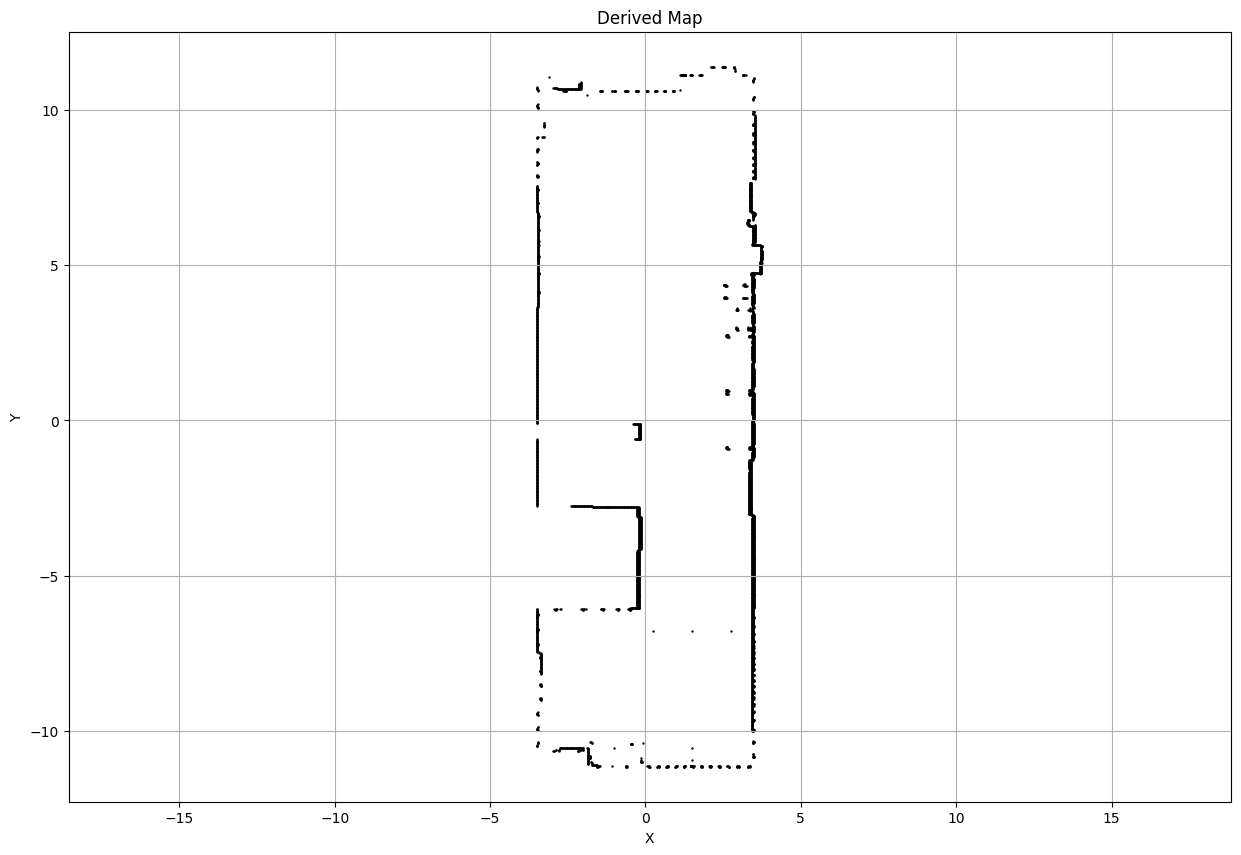

In [11]:
points = df[['x', 'y']].values
plt.figure(figsize=(15, 10))
plt.scatter(points[:, 0], points[:, 1], s=0.5, c='black')
plt.title("Derived Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis("equal")
plt.show()


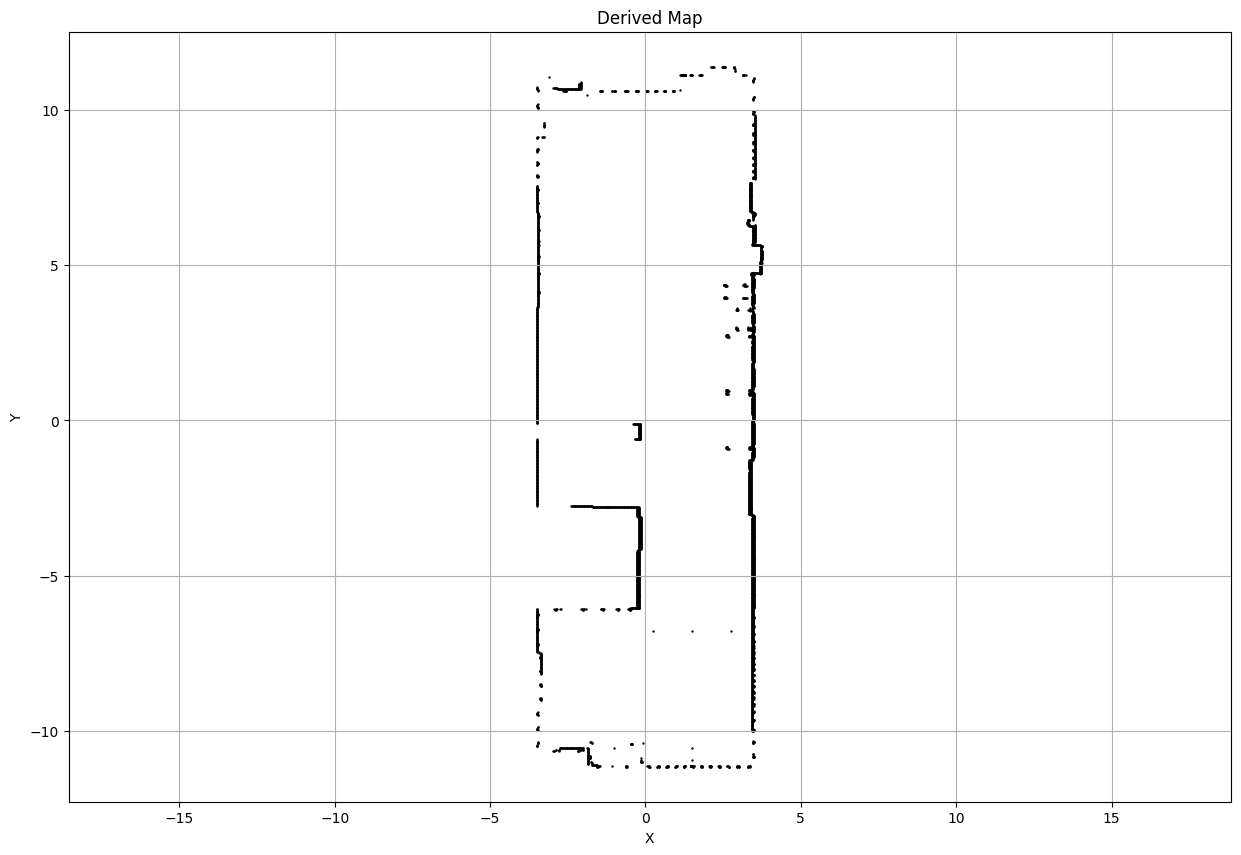

In [35]:
points = df[['x', 'y']].values
plt.figure(figsize=(15, 10))
plt.scatter(points[:, 0], points[:, 1], s=0.5, c='black')
plt.title("Derived Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis("equal")
plt.show()


In [28]:
# Iterative end-point fit (split) function
def iterative_end_point_fit(points, threshold):
    def fit_segment(start, end):
        segment = points[start:end+1]
        p1, p2 = segment[0], segment[-1]
        diffs = segment - p1
        if np.allclose(p1, p2):
            distances = np.linalg.norm(diffs, axis=1)
        else:
            v = p2 - p1
            v_unit = v / np.linalg.norm(v)
            proj = np.outer(np.dot(diffs, v_unit), v_unit)
            perp = diffs - proj
            distances = np.linalg.norm(perp, axis=1)
        if len(distances) > 2:
            idx_rel = np.argmax(distances[1:-1]) + 1
            dmax = distances[idx_rel]
        else:
            idx_rel, dmax = None, 0
        if dmax > threshold:
            idx_global = start + idx_rel
            return fit_segment(start, idx_global) + fit_segment(idx_global, end)
        else:
            return [(start, end)]
    return fit_segment(0, len(points)-1)

In [29]:
# Merge segments function
def merge_segments(segments, points, angle_thresh, dist_thresh):
    if not segments:
        return []
    merged = [segments[0]]
    for seg in segments[1:]:
        prev = merged[-1]
        p1_prev, p2_prev = points[prev[0]], points[prev[1]]
        p1_curr, p2_curr = points[seg[0]], points[seg[1]]
        v_prev = p2_prev - p1_prev
        v_curr = p2_curr - p1_curr
        cosang = np.dot(v_prev, v_curr) / (np.linalg.norm(v_prev)*np.linalg.norm(v_curr))
        angle = np.arccos(np.clip(cosang, -1, 1))
        endpoint_dist = np.linalg.norm(p2_prev - p1_curr)
        if angle < angle_thresh and endpoint_dist < dist_thresh:
            merged[-1] = (prev[0], seg[1])
        else:
            merged.append(seg)
    return merged

In [30]:
# Parameters
split_threshold = 0.1
merge_angle_thresh = np.deg2rad(5)
merge_dist_thresh = 0.05

In [31]:
# Define groups
left_sensors = ['ds1', 'ds2', 'ds3']
right_sensors = ['ds5', 'ds6', 'ds7']

groups = {
    'Left (d1,d2,d3)': left_sensors,
    'Right (d5,d6,d7)': right_sensors
}

C:\Users\pouri\AppData\Local\Temp\ipykernel_4016\1038992074.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(groups))  # You can change 'tab10' to 'viridis', 'Set1', etc.


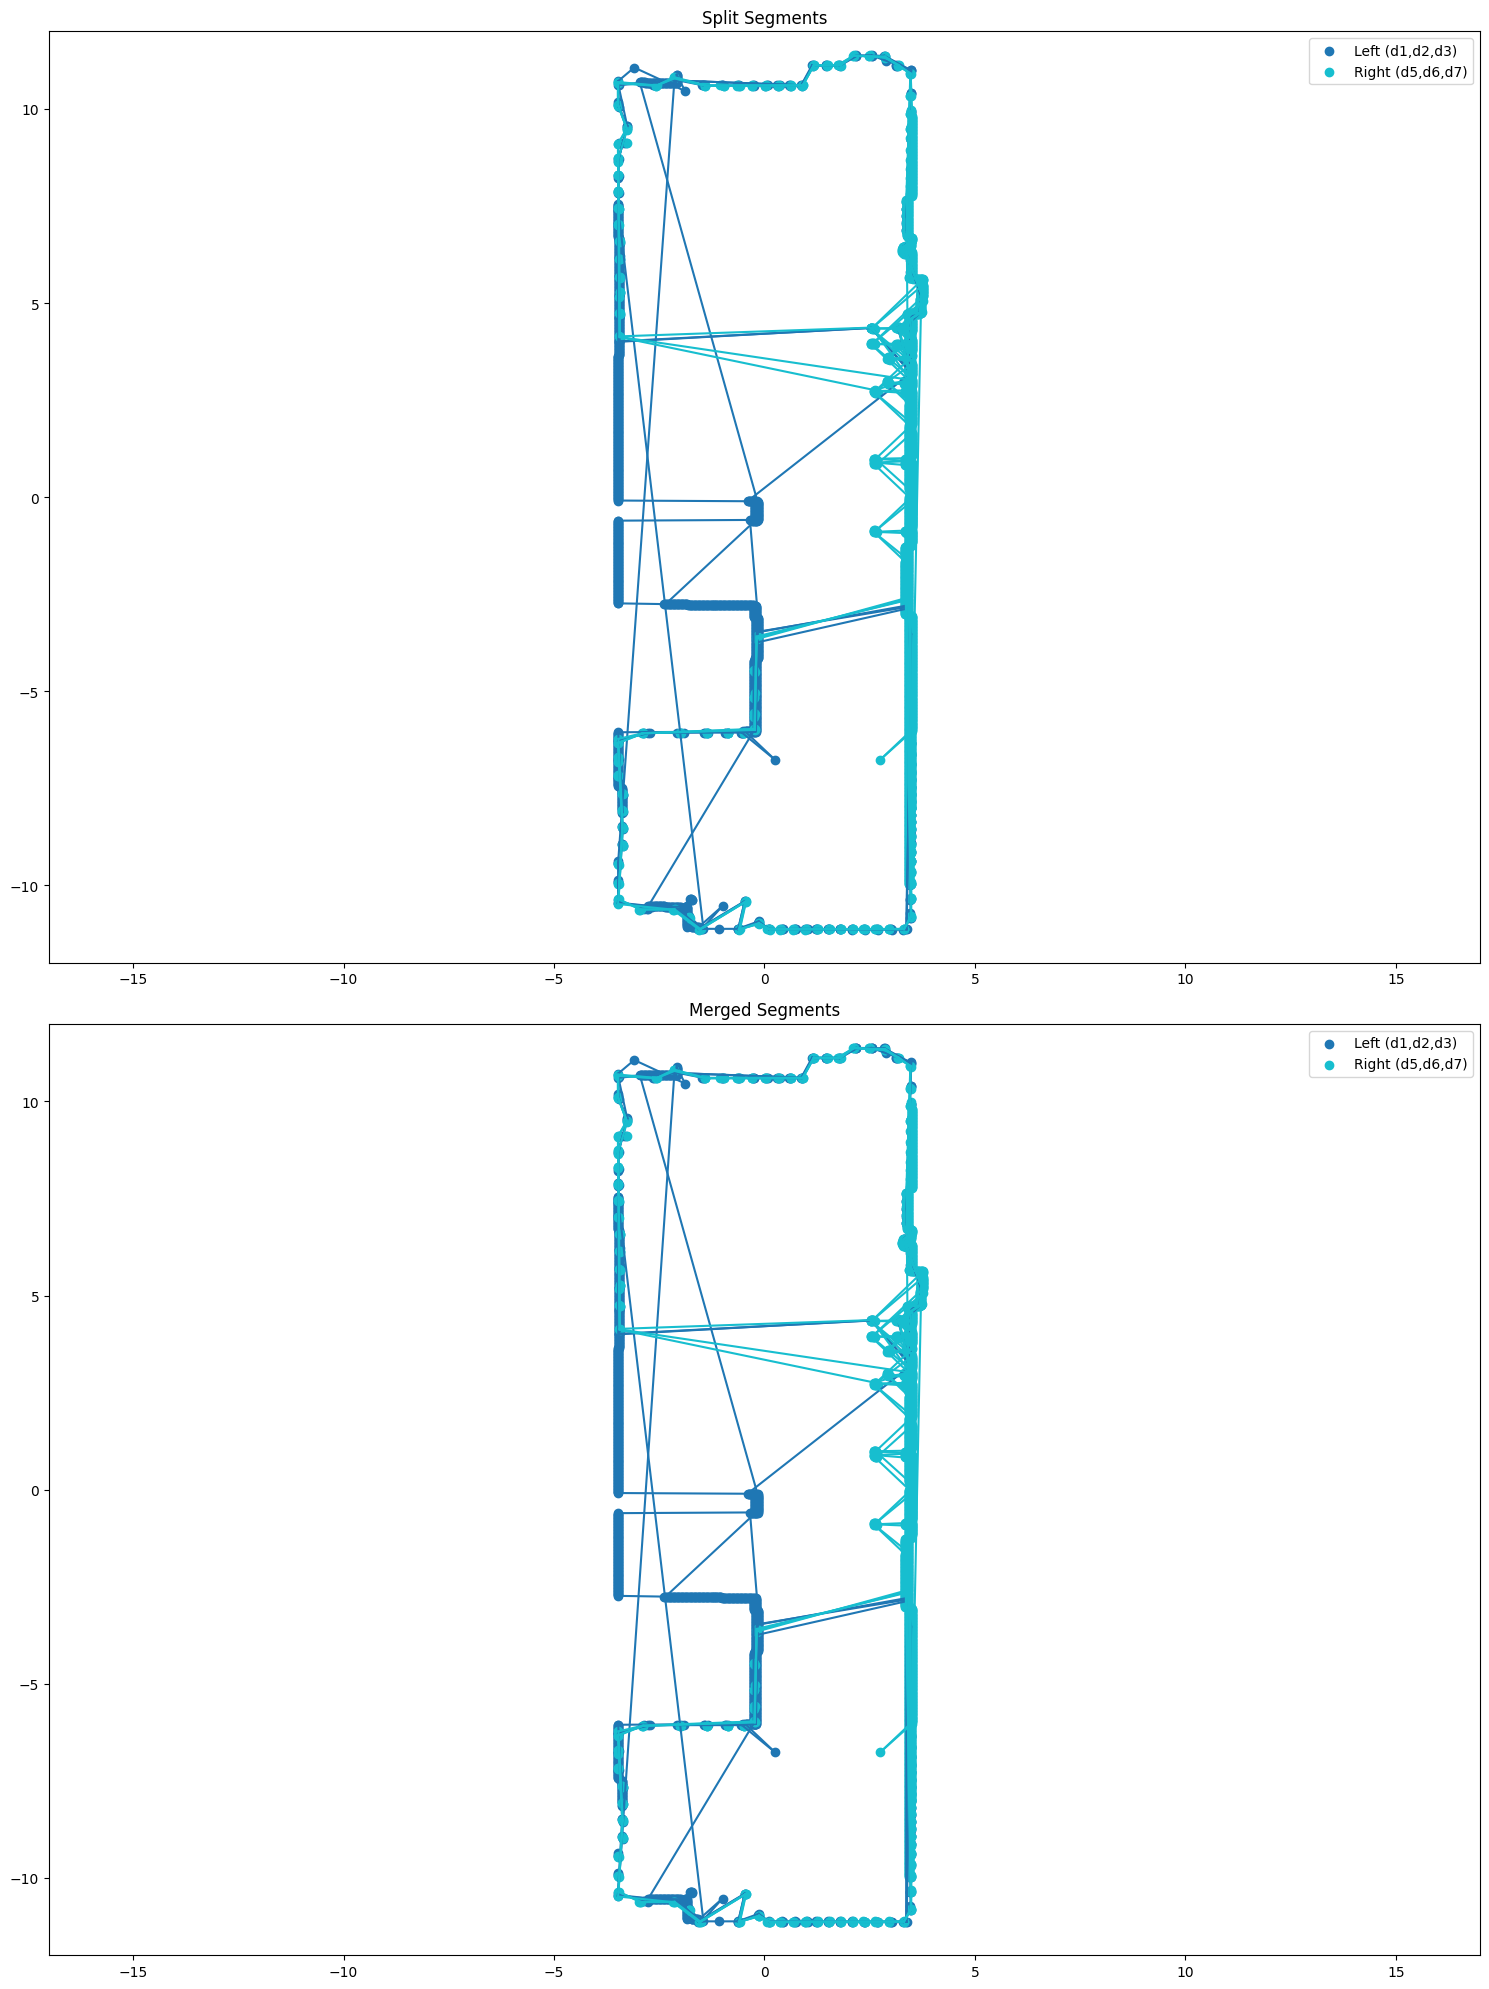

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
ax1, ax2 = axes

# Create a colormap with as many unique colors as there are groups
colors = cm.get_cmap('tab10', len(groups))  # You can change 'tab10' to 'viridis', 'Set1', etc.

for i, (title, sensors) in enumerate(groups.items()):
    color = colors(i)
    subset = df[df['sensor'].isin(sensors)]
    pts = subset.sort_values(['sensor_num', 'orig_idx'])[['x', 'y']].values

    # Apply split & merge
    split_segs = iterative_end_point_fit(pts, split_threshold)
    merged_segs = merge_segments(split_segs, pts, merge_angle_thresh, merge_dist_thresh)

    # Plot Split
    ax1.scatter(pts[:, 0], pts[:, 1], color=color, marker='o', label=title)
    for s, e in split_segs:
        p1, p2 = pts[s], pts[e]
        ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
    # Plot Merge
    ax2.scatter(pts[:, 0], pts[:, 1], color=color, marker='o', label=title)
    for s, e in merged_segs:
        p1, p2 = pts[s], pts[e]
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)

# Configure axes
ax1.set_title('Split Segments')
ax1.set_xlim(-17, 17)
ax1.set_ylim(-12, 12)
ax1.legend()

ax2.set_title('Merged Segments')
ax2.set_xlim(-17, 17)
ax2.set_ylim(-12, 12)
ax2.legend()

plt.tight_layout()
plt.show()
